<a href="https://colab.research.google.com/github/victormurcia/ridge_map/blob/master/Ridge_Map_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""3D maps with 1D lines."""
from urllib.request import urlopen
from tempfile import NamedTemporaryFile

from matplotlib.collections import LineCollection
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import rank
from skimage.morphology import square
from skimage.util import img_as_ubyte

import srtm

In [2]:
class FontManager:
    """Utility to load fun fonts from https://fonts.google.com/ for matplotlib.

    Find a nice font at https://fonts.google.com/, and then get its corresponding URL
    from https://github.com/google/fonts/

    Use like:

    fm = FontManager()
    fig, ax = plt.subplots()

    ax.text("Good content.", fontproperties=fm.prop, size=60)
    """

    def __init__(
        self,
        github_url="https://github.com/NDISCOVER/Cinzel/blob/master/fonts/ttf/Cinzel-Regular.ttf?raw=True",  # pylint: disable=line-too-long
    ):
        """
        Lazily download a font.

        Parameters
        ----------
        github_url : str
            Can really be any .ttf file, but probably looks like
            "https://github.com/google/fonts/blob/5c3d8ef085f3084db38936d0dcd39a567dbc1e01/ofl/cinzel/static/Cinzel-Regular.ttf?raw=True" # pylint: disable=line-too-long
        """
        self.github_url = github_url
        self._prop = None

    @property
    def prop(self):
        """Get matplotlib.font_manager.FontProperties object that sets the custom font."""
        if self._prop is None:
            with NamedTemporaryFile(delete=False, suffix=".ttf") as temp_file:
                # pylint: disable=consider-using-with
                temp_file.write(urlopen(self.github_url).read())
                self._prop = fm.FontProperties(fname=temp_file.name)
        return self._prop


class RidgeMap:
    """Main class for interacting with art.

    Keeps state around so no servers are hit too often.
    """

    def __init__(self, bbox=(-71.928864, 43.758201, -70.957947, 44.465151), font=None):
        """Initialize RidgeMap.

        Parameters
        ----------
        bbox : list-like of length 4
            In the form (long, lat, long, lat), describing the
            (bottom_left, top_right) corners of a box.
            http://bboxfinder.com is a useful way to find these tuples.
        font : matplotlib.font_manager.FontProperties
            Optional, a custom font to use. Defaults to Cinzel Regular.
        """
        self.bbox = bbox
        self._srtm_data = srtm.get_data()
        if font is None:
            font = FontManager().prop
        self.font = font

    @property
    def lats(self):
        """Left and right latitude of bounding box."""
        return (self.bbox[1], self.bbox[3])

    @property
    def longs(self):
        """Bottom and top longitude of bounding box."""
        return (self.bbox[0], self.bbox[2])

    def get_elevation_data(self, num_lines=80, elevation_pts=300, viewpoint="south"):
        """Fetch elevation data and return a numpy array.

        Parameters
        ----------
        num_lines : int
            Number of horizontal lines to draw
        elevation_pts : int
            Number of points on each line to request. There's some limit to
            this that srtm enforces, but feel free to go for it!
        viewpoint : str in ["south", "west", "north", "east"] (default "south")
            The compass direction from which the map will be visualised.

        Returns
        -------
        np.ndarray
        """
        if viewpoint in ["east", "west"]:
            num_lines, elevation_pts = elevation_pts, num_lines
        values = self._srtm_data.get_image(
            (elevation_pts, num_lines), self.lats, self.longs, 5280, mode="array"
        )

        switch = {"south": 0, "west": 3, "north": 2, "east": 1}
        rotations = switch[viewpoint]
        values = np.rot90(m=values, k=rotations)
        return values

    def preprocess(
        self, *, values=None, water_ntile=10, lake_flatness=3, vertical_ratio=40
    ):
        """Get map data ready for plotting.

        You can do this yourself, and pass an array directly to plot_map. This
        gathers all nan values, the lowest `water_ntile` percentile of elevations,
        and anything that is flat enough, and sets the values to `nan`, so no line
        is drawn. It also exaggerates the vertical scale, which can be nice for flat
        or mountainy areas.

        Parameters
        ----------
        values : np.ndarray
            An array to process, or fetch the elevation data lazily here.
        water_ntile : float in [0, 100]
            Percentile below which to delete data. Useful for coasts or rivers.
            Set to 0 to not delete any data.
        lake_flatness : int
            How much the elevation can change within 3 squares to delete data.
            Higher values delete more data. Useful for rivers, lakes, oceans.
        vertical_ratio : float > 0
            How much to exaggerate hills. Kind of arbitrary. 40 is reasonable,
            but try bigger and smaller values!

        Returns
        -------
        np.ndarray
            Processed data.
        """
        if values is None:
            values = self.get_elevation_data()
        nan_vals = np.isnan(values)

        values[nan_vals] = np.nanmin(values)
        values = (values - np.min(values)) / (np.max(values) - np.min(values))

        is_water = values < np.percentile(values, water_ntile)
        is_lake = rank.gradient(img_as_ubyte(values), square(3)) < lake_flatness

        values[nan_vals] = np.nan
        values[np.logical_or(is_water, is_lake)] = np.nan
        values = vertical_ratio * values[-1::-1]  # switch north and south
        return values

    # pylint: disable=too-many-arguments,too-many-locals
    def plot_map(
        self,
        values=None,
        label="The White\nMountains",
        label_x=0.62,
        label_y=0.15,
        label_verticalalignment="bottom",
        label_size=60,
        line_color="black",
        kind="gradient",
        linewidth=2,
        background_color=(0.9255, 0.9098, 0.9255),
        size_scale=20,
        ax=None,
    ):
        """Plot the map.

        Lots of nobs, and they're all useful to sometimes turn.

        Parameters
        ----------
        values : np.ndarray
            Array of elevations to plot. Defaults to the elevations at the provided
            bounding box.
        label : string
            Label to place on the map. Use an empty string for no label.
        label_x : float in [0, 1]
            Where to position the label horizontally
        label_y : float in [0, 1]
            Where to position the label vertically
        label_verticalalignment: "top" or "bottom"
            Whether the label_x and label_y refer to the top or bottom left corner
            of the label text box
        label_size : int
            fontsize of the label
        line_color : string or callable
            colors for the map. A callable will be fed the scaled index in [0, 1]
        kind : {"gradient" | "elevation"}
            If you provide a colormap to `line_color`, "gradient" colors by the line index, and
            "elevation" colors by the actual elevation along the line.
        linewidth : float
            Width of each line in the map
        background_color : color
            For the background of the map and figure
        scale_size : float
            If you are printing this, make this number bigger.
        ax : matplotlib Axes
            You can pass your own axes!

        Returns
        -------
        matplotlib.Axes
        """
        if kind not in {"gradient", "elevation"}:
            raise TypeError("Argument `kind` must be one of 'gradient' or 'elevation'")
        if values is None:
            values = self.preprocess()

        if ax is None:
            ratio = (self.lats[1] - self.lats[0]) / (self.longs[1] - self.longs[0])
            _, ax = plt.subplots(figsize=(size_scale, size_scale * ratio))

        x = np.arange(values.shape[1])
        norm = plt.Normalize(np.nanmin(values), np.nanmax(values))
        for idx, row in enumerate(values):
            y_base = -6 * idx * np.ones_like(row)
            y = row + y_base
            if callable(line_color) and kind == "elevation":
                points = np.array([x, y]).T.reshape((-1, 1, 2))
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lines = LineCollection(
                    segments, cmap=line_color, zorder=idx + 1, norm=norm
                )
                lines.set_array(row)
                lines.set_linewidth(linewidth)
                ax.add_collection(lines)
            else:
                if callable(line_color) and kind == "gradient":
                    color = line_color(idx / values.shape[0])
                else:
                    color = line_color

                ax.plot(x, y, "-", color=color, zorder=idx, lw=linewidth)
            ax.fill_between(x, y_base, y, color=background_color, zorder=idx)

        ax.text(
            label_x,
            label_y,
            label,
            transform=ax.transAxes,
            fontproperties=self.font,
            size=label_size,
            verticalalignment=label_verticalalignment,
            bbox=dict(facecolor=background_color, alpha=1, linewidth=0),
            zorder=len(values) + 10,
        )

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_facecolor(background_color)
        return ax

4 25934402
4 25934402
4 25934402
4 25934402


<Axes: >

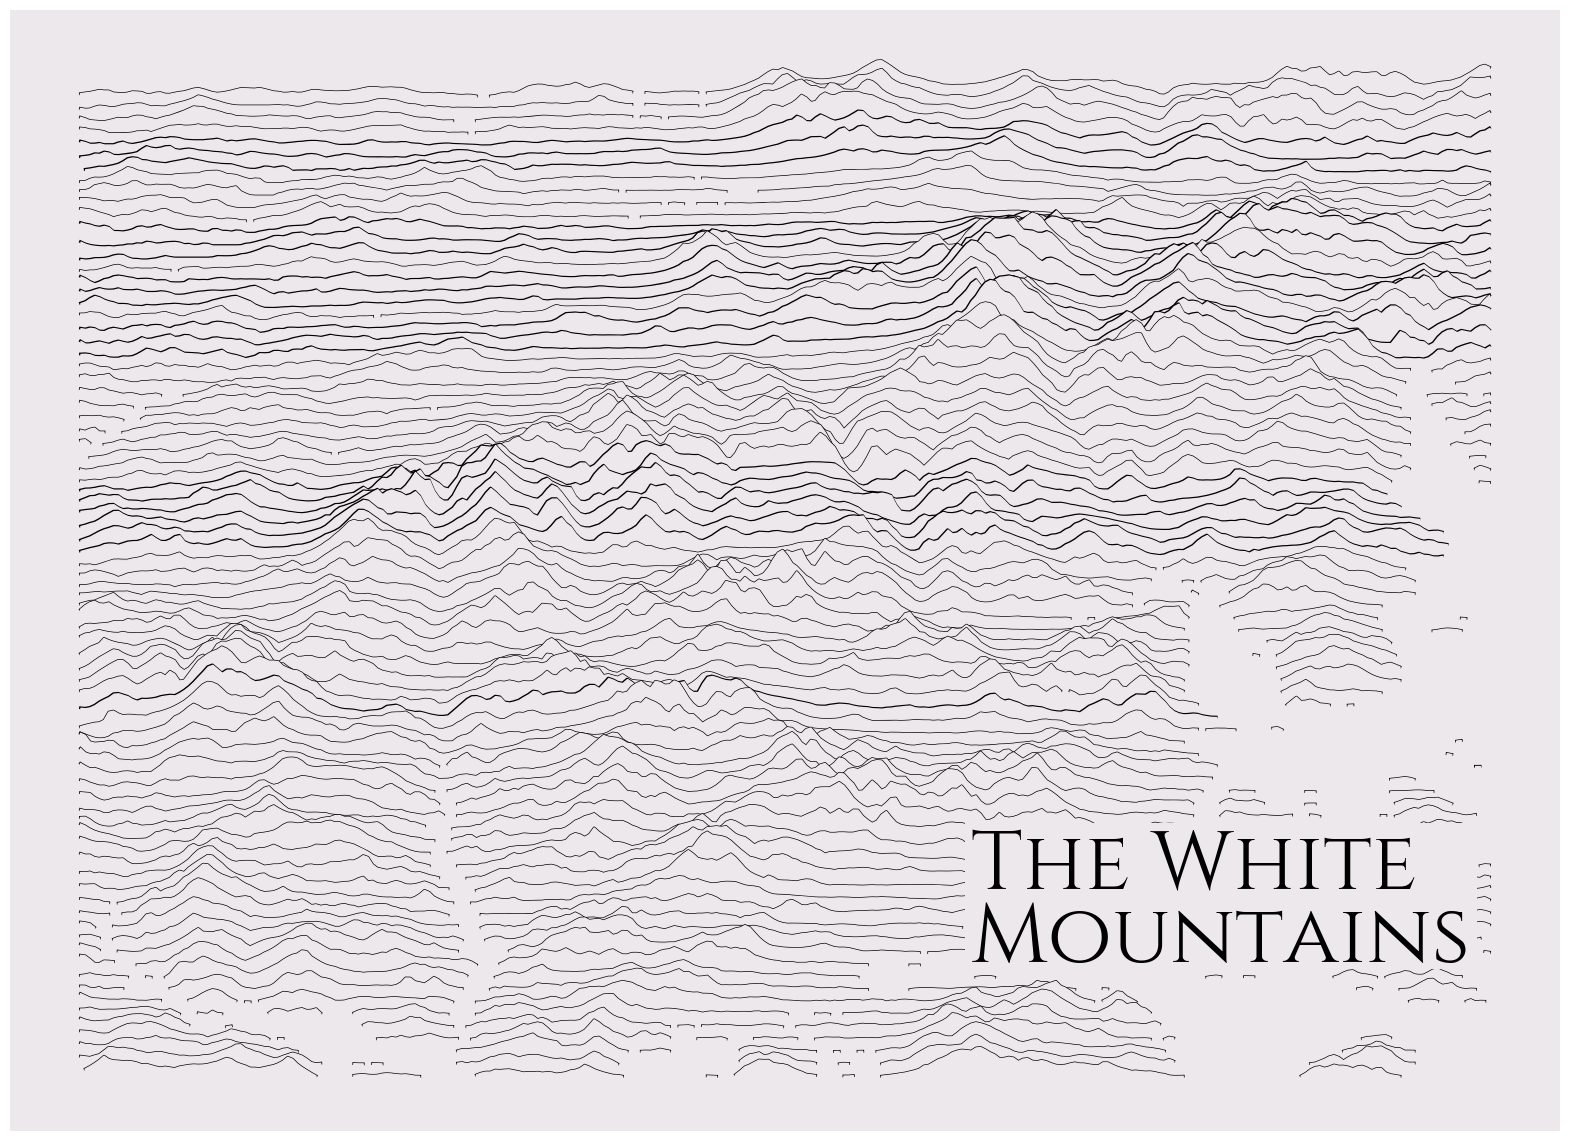

In [3]:
RidgeMap().plot_map()

<Axes: >

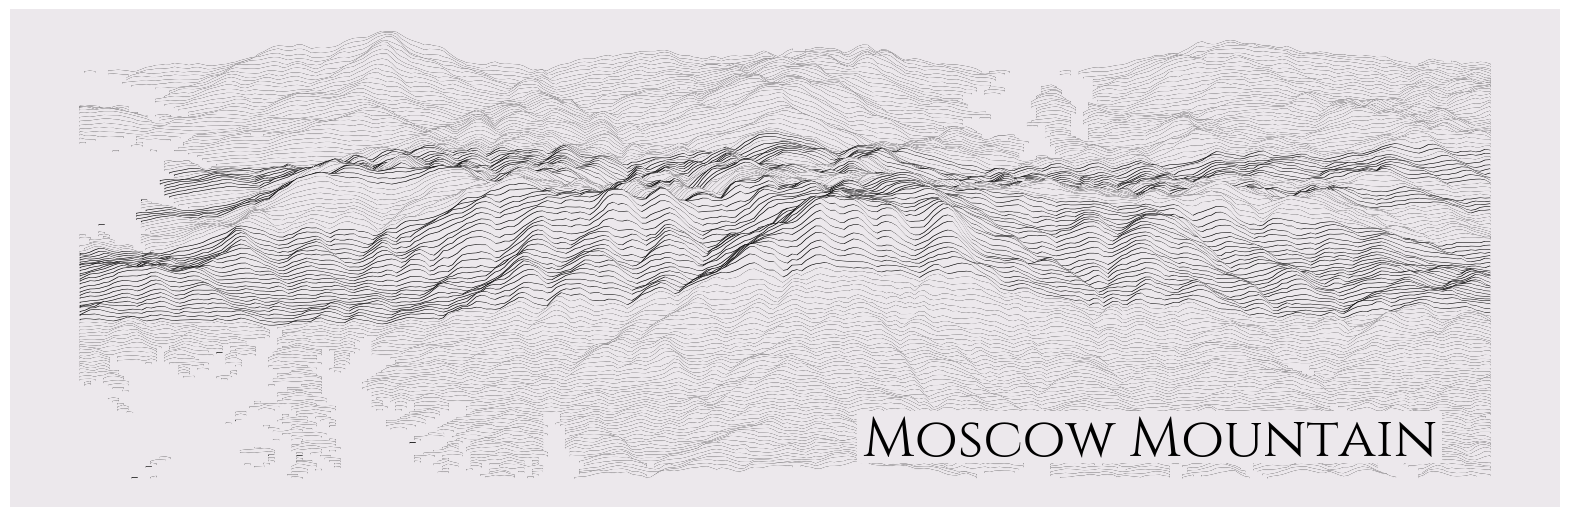

In [6]:
rm = RidgeMap((-117.039242,46.757504,-116.712570,46.863125))
values = rm.get_elevation_data(num_lines=150)
values=rm.preprocess(
    values=values,
    lake_flatness=2,
    water_ntile=10,
    vertical_ratio=240)
rm.plot_map(values=values,
            label='Moscow Mountain',
            label_y=0.1,
            label_x=0.55,
            label_size=40,
            linewidth=1)

<Axes: >

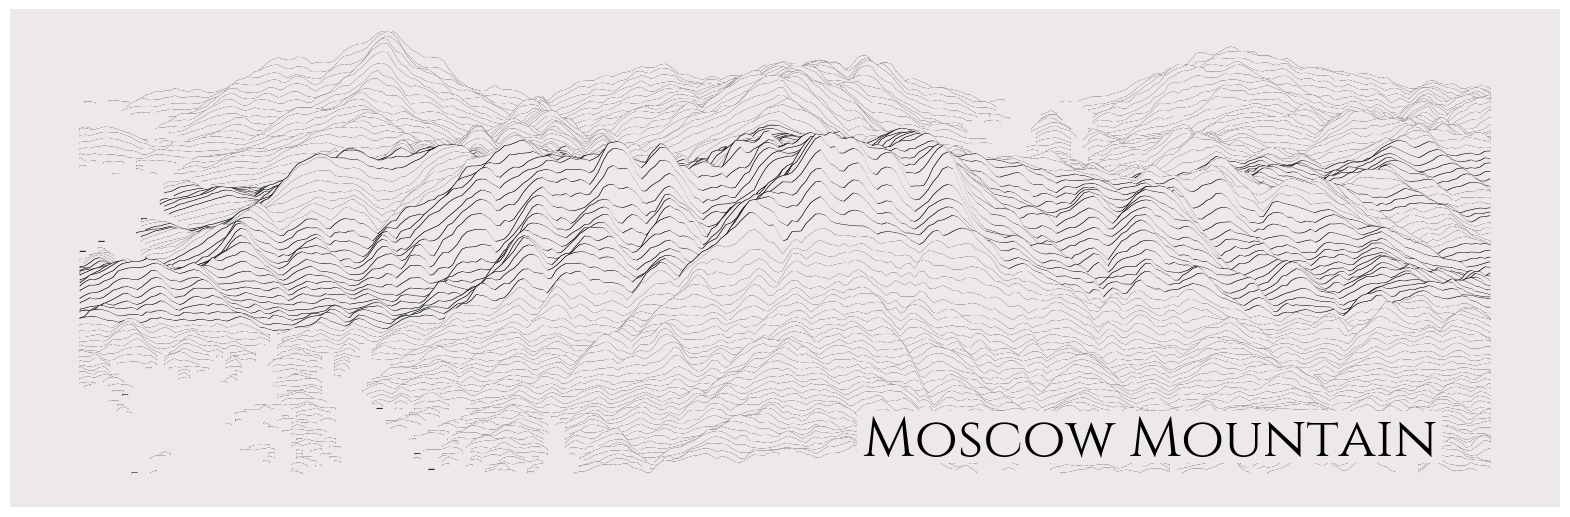

In [10]:
rm = RidgeMap((-117.039242,46.757504,-116.712570,46.863125))
values = rm.get_elevation_data(num_lines=100)
values=rm.preprocess(
    values=values,
    lake_flatness=2,
    water_ntile=10,
    vertical_ratio=300)
rm.plot_map(values=values,
            label='Moscow Mountain',
            label_y=0.1,
            label_x=0.55,
            label_size=40,
            linewidth=1)

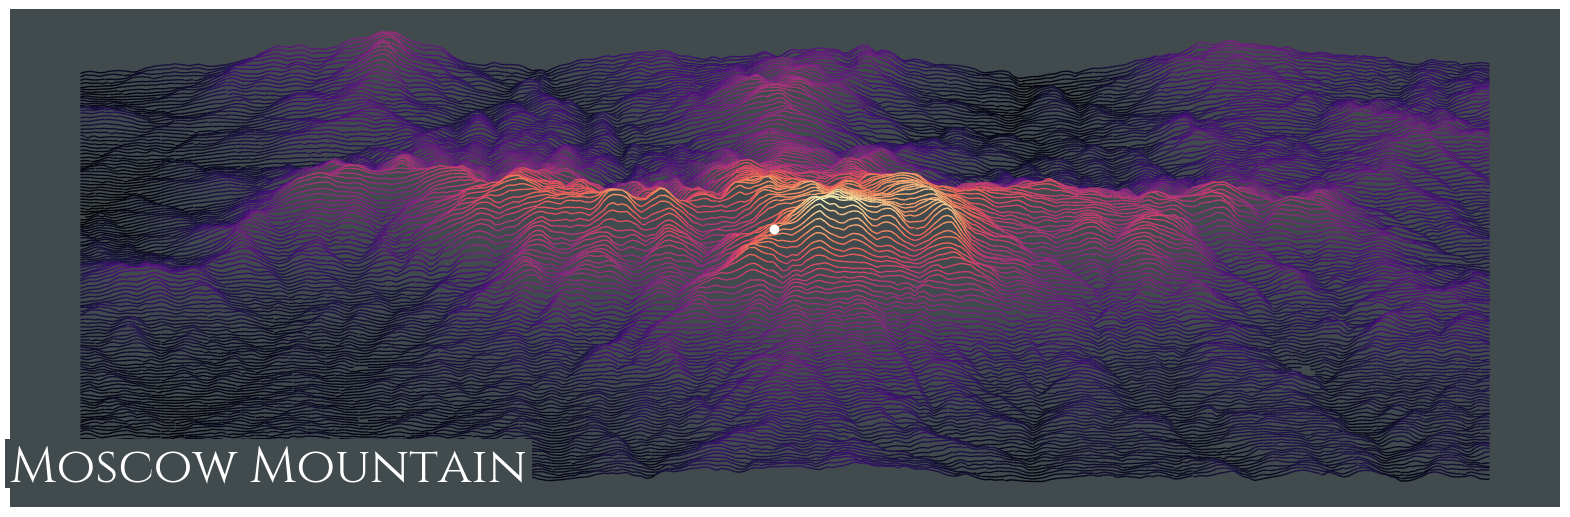

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

bgcolor = np.array([65,74,76])/255.

scipp = (-116.878223,46.816391)
rm = RidgeMap((-117.039242,46.757504,-116.712570,46.863125))
scipp_coords = ((scipp[0] - rm.longs[0])/(rm.longs[1] - rm.longs[0]),(scipp[1] - rm.lats[0])/(rm.lats[1] - rm.lats[0]))

values = rm.get_elevation_data(num_lines=150)
ridges = rm.plot_map(values=rm.preprocess(values=values,
                                          lake_flatness=1,
                                          water_ntile=0,
                                          vertical_ratio=240),
            label='Moscow Mountain',
            label_x=0.0,
            label_y=0.05,
            label_size=36,
            kind='elevation',
            linewidth=1,
            background_color=bgcolor,
            line_color = plt.get_cmap('magma'))

# Bit of a hack to update the text label color
for child in ridges.get_children():
    if isinstance(child, matplotlib.text.Text) and 'Moscow Mountain' in child._text:
        label_artist = child
        break
label_artist.set_color('white')

ridges.plot(*scipp_coords, 'o',
            color='white',
            transform=ridges.transAxes,
            ms=6,
            zorder=len(values)+10)